In [ ]:
!pip install scikit-plot

###Import libraries

In [ ]:
#@title
import warnings
warnings.filterwarnings('ignore')
#Loading all the required packages

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid')
cmap = sns.cm.mako_r

# Scikit-learn
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Google drive
from google.colab import drive

# nltk
import re
from nltk import word_tokenize, corpus
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download(['words','punkt','vader_lexicon','stopwords','wordnet'])

english_words = set(corpus.words.words())

from IPython.core.display import HTML
HTML("""<style> 
            .output_png { display: table-cell; text-align: center; vertical-align: middle; } 
     </style> """)


#numpy
import numpy as np # linear algebra
#counter
from collections import Counter, defaultdict
from urllib.request import urlopen
from zipfile import ZipFile
#pytorch models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

#handling text data
from torchtext import data 
from torch.autograd import Variable
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
#gc
import gc

from datetime import datetime
import time
import os
#Google colab
from google.colab import drive
drive.mount('/content/drive')

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Mounted at /content/drive
Using device: cuda

Tesla V100-SXM2-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Data Transformation

In [ ]:
#@title Read CSV file 
#Read the csv file
pdfReddit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Text Classification/reddit_wsb.csv')
pdfReddit.drop(columns=['id', 'url', 'created'], inplace=True)
pdfReddit.head()

,title,score,comms_num,body,timestamp
0,"It's not about the money, it's about sending a...",55,6,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,23,NaN,2021-01-28 21:32:10
2,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,156,NaN,2021-01-28 21:26:56


###Clean text data

In [ ]:
#@title Text Preprocessing
pdfReddit_title = pdfReddit['title'].dropna()
pdfReddit_body = pdfReddit['body'].dropna()
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def clean_text_data(text):
    text = text.lower()

    # Replacing Handlers with Empty String
    text = re.sub('@[^\s]+','',text)

    # Replacing URLs with Empty String
    text = re.sub(r"http\S+", "",text)

    # Remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # Replacing Single Characters with Empty String
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Removing Extra Spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Tokenize into words
    text = word_tokenize(text)

    # Word Lemmatization
    lem = WordNetLemmatizer()
    text = ' '.join([lem.lemmatize(w) for w in text])
    # return text
    tokens = []
    for token in text.split():
      if token not in stop_words:
        tokens.append(stemmer.stem(token))
    return " ".join(tokens)
    
# Text Preprocessing
pdfReddit_title = pdfReddit_title.apply(lambda x : clean_text_data(x))
pdfReddit_body = pdfReddit_body.apply(lambda x : clean_text_data(x))

### Get the sentiment labels for the body and title columns

Find the sentiment polarity using NLTK sentiment analyzer and create the labels as Positive, Negative, and Neutral

In [ ]:
#@title Sentiment polarity from NLTK
def get_sentiment(model, text):
    if model.polarity_scores(text)["compound"] > 0:
        return "Positive"
    elif model.polarity_scores(text)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"

def get_sentimentScore(model, text):
    if model.polarity_scores(text)["compound"] > 0:
        return 2
    elif model.polarity_scores(text)["compound"] < 0:
        return 1
    else:
        return 0

model = SentimentIntensityAnalyzer()    
 
pdfreddit = pdfReddit_body.to_frame(name='text')
pdfreddit['sentimentlabel'] = pdfreddit['text'].apply(lambda x : get_sentiment(model, x))
pdfreddit['sentiment'] = pdfreddit['text'].apply(lambda x : get_sentimentScore(model, x))
pdfreddit['length'] = pdfreddit['text'].apply(lambda s: len(s.split()))
pdfreddit.sort_values(by=['length'], ascending=False, inplace=True)
pdfreddit=pdfreddit[pdfreddit.length >1]
pdfreddit=pdfreddit.reset_index()

In [ ]:
#@title List of labels
class_names = pdfreddit.sentimentlabel.unique()
class_names

array(['Positive', 'Negative', 'Neutral'], dtype=object)

###Plot the sentiment label distribution

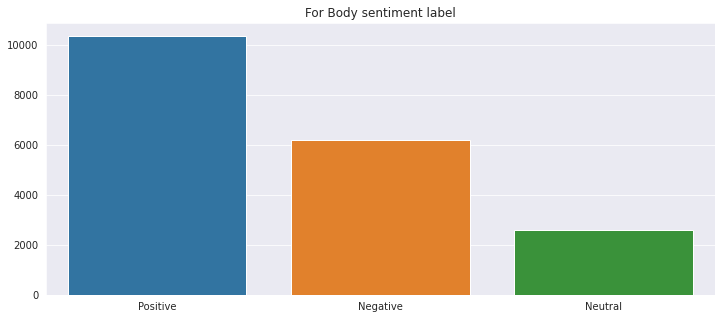

In [ ]:
#@title
fig, (axis) = plt.subplots(1,1, figsize=(12,5))
order = ['Positive', 'Negative','Neutral']

xs = pdfreddit['sentimentlabel'].value_counts().index
ys = pdfreddit['sentiment'].value_counts().values
sns.barplot(x=xs, y=ys, order=order, ax=axis)

axis.set_title("For Body sentiment label")

plt.show()

In [ ]:
pdfreddit.shape

(19144, 5)

#Load tokenizer

In [ ]:
#@title pytorch tokenizer
tokenizer = get_tokenizer('basic_english')

In [ ]:
#@title Generate token frequency dictionary
# This step takes few minutes
counter = Counter()
for _, row in pdfreddit.iterrows():
    counter.update(tokenizer(row['text']))

vocab = Vocab(counter, min_freq=1)

In [ ]:
#@title
print(f"Size of TEXT vocabulary: {len(vocab)}\n")

print(f"Commonly used words: {vocab.freqs.most_common(10)}\n")

Size of TEXT vocabulary: 33109

Commonly used words: [('stock', 15913), ('share', 14910), ('short', 14318), ('gme', 13386), ('buy', 12558), ('go', 12461), ('like', 11404), ('wa', 11151), ('market', 11040), ('price', 10523)]



In [ ]:
#@title text and label pipeline
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

label_pipeline = lambda x: int(x)

### Split the dataset into training and test dataset

In [ ]:
#@title Split training and test dataset
# Use train_test_split to split our data into train and validation sets for training
df_train, df_test = train_test_split(pdfreddit, random_state=RANDOM_SEED, test_size=0.1)

print("Training dataset shape {} Test dataset shape {} ".format(df_train.shape, df_test.shape))

df_train.sort_values(by=['length'], ascending=False, inplace=True)
df_test.sort_values(by=['length'], ascending=False, inplace=True)

Training dataset shape (17229, 5) Test dataset shape (1915, 5) 


### Split training and test dataset

Padd the X sequences and convert y into int

In [ ]:
#@title Training and dataset split and pad sequences
train_X, test_X, train_y, test_y = train_test_split(pdfreddit['text'], pdfreddit['sentimentlabel'],
                                                    stratify=pdfreddit['sentimentlabel'], 
                                                    test_size=0.1)
print("Train shape : {} Test shape : {} ".format(train_X.shape,test_X.shape))

embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 400 # max number of words in a question to use

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

Train shape : (17229,) Test shape : (1915,) 


###Glove pretrained embedding

In [ ]:
#@title Open Glove .zip file
# load the whole embedding into memory
# open and save the zip file onto local folder from website
# Download the .zip file into local

EMBEDDING_FILE = 'http://nlp.stanford.edu/data/glove.6B.zip'
url = urlopen(EMBEDDING_FILE)
output = open('glove.6B.zip', 'wb')         
output.write(url.read())
output.close()
#Extract the .zip file
zGlove = ZipFile('glove.6B.zip') 
zGlove.extractall()

#Delete the .zip file from the local folder
os.remove('glove.6B.zip')
os.remove('glove.6B.200d.txt')
os.remove('glove.6B.100d.txt')	
os.remove('glove.6B.50d.txt')

In [ ]:
#@title Load Glove .Zip file
def load_glove(word_index):
    EMBEDDING_FILE = 'glove.6B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = load_glove(tokenizer.word_index)

In [ ]:
np.shape(embedding_matrix)

(30911, 300)

###BiLSTM model

In [ ]:
#@title BiLSTM model with attention layer
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)

        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0

        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)

        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))

    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim),
            self.weight
        ).view(-1, step_dim)

        if self.bias:
            eij = eij + self.b

        eij = torch.tanh(eij)
        a = torch.exp(eij)

        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)
        
class BiLSTM(nn.Module):   
    def __init__(self):
      super(BiLSTM, self).__init__()
      self.hidden_size = 64
      drop_out = 0.1
      n_classes = len(le.classes_)
      self.embedding = nn.Embedding(max_features, embed_size)
      self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
      self.embedding.weight.requires_grad = False

      self.embedding_dropout = nn.Dropout2d(drop_out)
      self.lstm = nn.LSTM(embed_size, 128, bidirectional=True, batch_first=True)
      self.lstm2 = nn.GRU(128*2, 64, bidirectional=True, batch_first=True)

      self.attention_layer = Attention(128, maxlen)

      self.linear = nn.Linear(64*2 , 64)
      self.relu = nn.ReLU()
      self.out = nn.Linear(64, n_classes)

    def forward(self, x):
      h_embedding = self.embedding(x)
      h_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
      h_lstm, _ = self.lstm(h_embedding)
      h_lstm, _ = self.lstm2(h_lstm)
      h_lstm_atten = self.attention_layer(h_lstm)
      conc = self.relu(self.linear(h_lstm_atten))
      out = self.out(conc)
      return out

In [ ]:
#@title Train the model
n_epochs = 25
batch_size = 16
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

#getting epchos history
history = defaultdict(list)

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0. 
    train_preds = np.zeros((len(x_train),len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    train_acc = sum(train_preds.argmax(axis=1)==train_y)/len(train_y)
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    history['train_acc'].append(train_acc)
    history['train_loss'].append(avg_loss)
    history['val_acc'].append(val_accuracy)
    history['val_loss'].append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t train loss={:.4f} \t val_loss={:.4f}  \t train_acc={:.4f} \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, train_acc, val_accuracy, elapsed_time))

Epoch 1/25 	 train loss=9.8794 	 val_loss=5.2691  	 train_acc=0.3240 	 val_acc=0.8710  	 time=48.30s
Epoch 2/25 	 train loss=4.9529 	 val_loss=3.8876  	 train_acc=0.3240 	 val_acc=0.9170  	 time=46.35s
Epoch 3/25 	 train loss=3.5366 	 val_loss=3.5123  	 train_acc=0.3240 	 val_acc=0.9201  	 time=47.81s
Epoch 4/25 	 train loss=2.3992 	 val_loss=3.5903  	 train_acc=0.3240 	 val_acc=0.9191  	 time=46.95s
Epoch 5/25 	 train loss=1.5232 	 val_loss=4.5622  	 train_acc=0.3240 	 val_acc=0.9128  	 time=47.20s
Epoch 6/25 	 train loss=1.0828 	 val_loss=4.6843  	 train_acc=0.3240 	 val_acc=0.9175  	 time=47.94s
Epoch 7/25 	 train loss=0.7327 	 val_loss=5.1617  	 train_acc=0.3240 	 val_acc=0.9159  	 time=46.64s
Epoch 8/25 	 train loss=0.6279 	 val_loss=5.5637  	 train_acc=0.3240 	 val_acc=0.9117  	 time=47.70s
Epoch 9/25 	 train loss=0.5222 	 val_loss=6.2313  	 train_acc=0.3240 	 val_acc=0.9159  	 time=47.00s
Epoch 10/25 	 train loss=0.4508 	 val_loss=6.8933  	 train_acc=0.3240 	 val_acc=0.9107  	 t

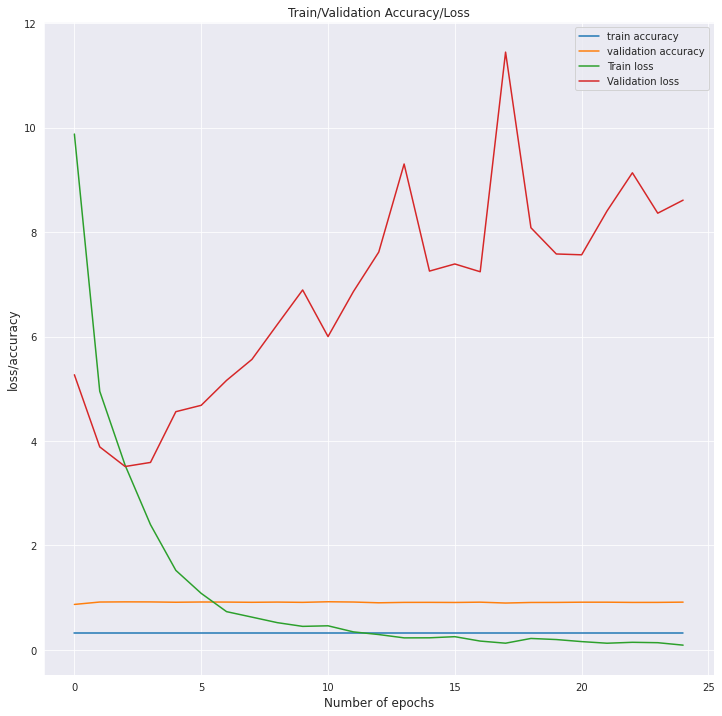

In [ ]:
#@title Plot graph
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Accuracy/Loss")
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')
    plt.plot(history['train_loss'], label='Train loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.xlabel('Number of epochs', fontsize=12)
    plt.ylabel('loss/accuracy', fontsize=12)
    plt.legend(loc='best')
plot_graph(n_epochs)

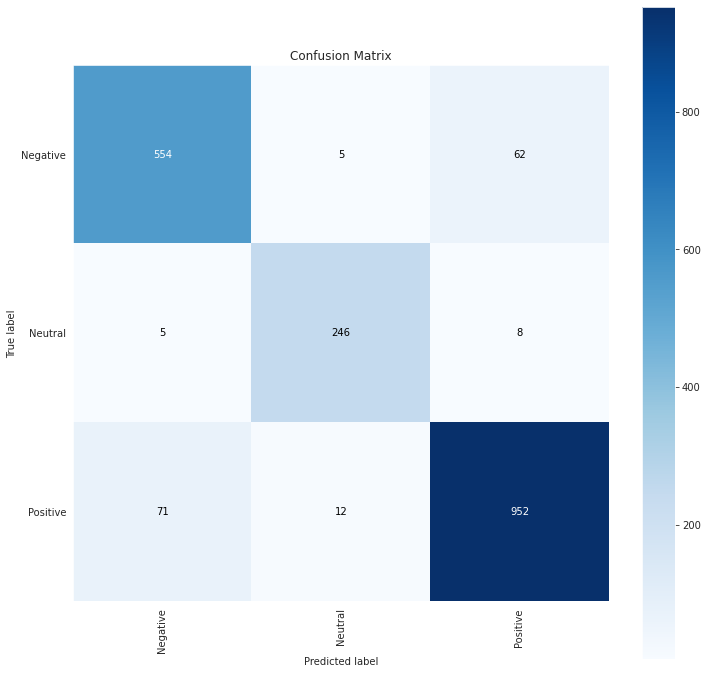

In [ ]:
#@title Confusion Matrix
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

### Classification Report

In [ ]:
#@title Display classification report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Positive       0.88      0.89      0.89       621
    Negative       0.94      0.95      0.94       259
     Neutral       0.93      0.92      0.93      1035

    accuracy                           0.91      1915
   macro avg       0.92      0.92      0.92      1915
weighted avg       0.92      0.91      0.91      1915

